In [1]:
import numpy as np
import pandas as pd
import pickle
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

with open('pred.pkl', 'rb') as f:
    preds = pickle.load(f)
    
with open('actual.pkl', 'rb') as f:
    actual = pickle.load(f)

print(len(actual))
print(len(preds))

4349
4349


In [15]:
data = pd.read_csv('../final_data.csv')
data_train = data.sample(frac=0.8,random_state=17)
data_val = data.loc[~data.index.isin(data_train.index)]
id_train = data_train.index.tolist()
id_val = data_val.index.tolist()

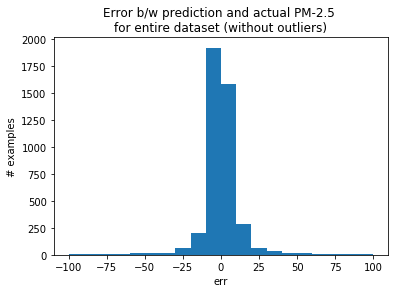

-1.0209343402817157
28.785676234594458


In [37]:
err = np.array(preds)-np.array(actual)
plt.hist(err, bins=20,range=(-100,100))
plt.title("Error b/w prediction and actual PM-2.5 \nfor entire dataset (without outliers)")
plt.xlabel('err')
plt.ylabel('# examples')
plt.savefig('err_full.png')
plt.show()
print(np.mean(err))
print(np.std(err))

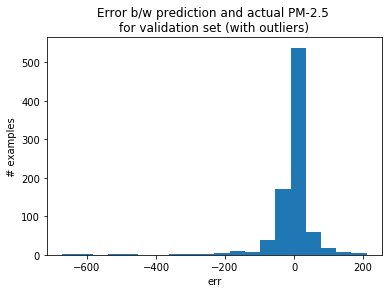

-5.634183343799635
62.37702370827587


In [38]:
err_train = err[np.array(id_train)]
err_val = err[np.array(id_val)]
plt.hist(err_val, bins=20)
plt.title("Error b/w prediction and actual PM-2.5 \nfor validation set (with outliers)")
plt.xlabel('err')
plt.ylabel('# examples')
plt.savefig('err_val.png')
plt.show()
print(np.mean(err_val))
print(np.std(err_val))

In [20]:
id_china = []
id_delhi = []
for index, row in data.iterrows():
    filename = row['filename']
    if filename.startswith('Shanghai1') or filename.startswith('Shanghai2') or filename.startswith('Shanghai3') or filename.startswith('Beijing'):
        id_china.append(index)
    else:
        id_delhi.append(index)

print(len(id_china))
print(len(id_delhi))

2229
2120


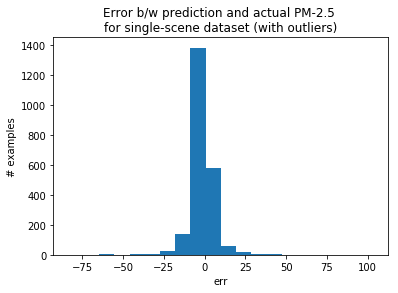

-1.6289070456110346
8.360367447086235


In [39]:
err_china = err[np.array(id_china)]
err_delhi = err[np.array(id_delhi)]
plt.hist(err_china, bins=20)
plt.title("Error b/w prediction and actual PM-2.5 \nfor single-scene dataset (with outliers)")
plt.xlabel('err')
plt.ylabel('# examples')
plt.savefig('err_china.png')
plt.show()
print(np.mean(err_china))
print(np.std(err_china))

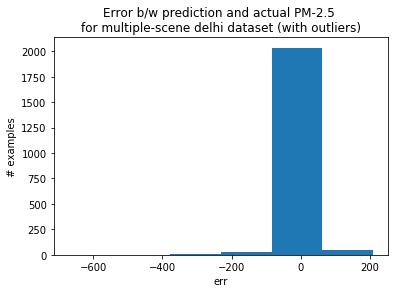

-0.38170266095197425
40.31807220502668


In [40]:
plt.hist(err_delhi, bins=6)
plt.title("Error b/w prediction and actual PM-2.5 \nfor multiple-scene delhi dataset (with outliers)")
plt.xlabel('err')
plt.ylabel('# examples')
plt.savefig('err_delhi.png')
plt.show()
print(np.mean(err_delhi))
print(np.std(err_delhi))

In [48]:
# find good vs bad examples from above errs
abs_err = np.abs(err)
ind = np.argpartition(abs_err, -20)[-20:] # indices of highest abs error
err_ind = abs_err[ind] # highest abs error
print(err_ind[0])
print(preds[ind[0]])
print(actual[ind[0]])
list(data.iloc[ind[0]])

173.68968963623047
205.13052368164062
31.440834045410156


['30076928_1127121560758096_3274023105537769472_n', 31.44083333333333]

In [68]:
print(err_ind[2])
print(preds[ind[2]])
print(actual[ind[2]])
list(data.iloc[ind[2]])

195.84106826782227
238.9103546142578
43.06928634643555


['37672324_279736822801516_8078809865750839296_n', 43.06928571428572]

In [69]:
print(err_ind[4])
print(preds[ind[4]])
print(actual[ind[4]])
list(data.iloc[ind[4]])

199.61647033691406
190.0956573486328
389.7121276855469


['47253026_157163518610448_2136220676494070664_n', 389.71214285714285]

In [65]:
print(err_ind[5])
print(preds[ind[5]])
print(actual[ind[5]])
list(data.iloc[ind[5]])

347.5932083129883
73.4367904663086
421.0299987792969


['23422033_150729815537066_7609480750454276096_n', 421.03]

In [70]:
print(err_ind[6])
print(preds[ind[6]])
print(actual[ind[6]])
list(data.iloc[ind[6]])

276.9127502441406
101.18341064453125
378.0961608886719


['43984815_1888703911227305_1679019398446941429_n', 378.0961538461537]

In [71]:
print(err_ind[7])
print(preds[ind[7]])
print(actual[ind[7]])
list(data.iloc[ind[7]])

523.4844818115234
209.37049865722656
732.85498046875


['46848680_526463111201161_7042018332420154853_n', 732.855]

In [74]:
ind2 = np.argpartition(abs_err, 20)[20:] # indices of lowest abs error
err_ind2 = abs_err[ind2] # lowest abs error
print(err_ind2[0])
print(preds[ind2[0]])
print(actual[ind2[0]])
list(data.iloc[ind2[0]])

0.3772239685058594
52.05363845825195
116.98928833007812


['39998224_534523936977655_1443455142570583622_n', 116.98928571428571]

In [72]:
print(err_ind2[9])
print(preds[ind2[9]])
print(actual[ind2[9]])
list(data.iloc[ind2[9]])

0.0346832275390625
121.70832061767578
121.67363739013672


['29908859_405140603286124_1262735481834045440_nframe6', 121.67363636363638]

In [73]:
print(err_ind2[10])
print(preds[ind2[10]])
print(actual[ind2[10]])
list(data.iloc[ind2[10]])

0.03765869140625
284.3751525878906
284.3374938964844


['24504544_859172164262333_8779574947354771456_nframe25', 284.3375]

In [53]:
print(err_ind2[1])
print(preds[ind2[1]])
print(actual[ind2[1]])
list(data.iloc[ind2[1]])

0.0279083251953125
84.97209167480469
85.0


['Shanghai3/201412301445_mod', 85.0]

In [55]:
print(err_ind2[2])
print(preds[ind2[2]])
print(actual[ind2[2]])
list(data.iloc[ind2[2]])

0.028392791748046875
32.02839279174805
32.0


['Shanghai2/201411231045_mod', 32.0]

In [56]:
print(err_ind2[3])
print(preds[ind2[3]])
print(actual[ind2[3]])
list(data.iloc[ind2[3]])

0.0306396484375
65.9693603515625
66.0


['Shanghai1/201407261245_mod', 66.0]

In [63]:
print(err_ind2[11])
print(preds[ind2[11]])
print(actual[ind2[11]])
list(data.iloc[ind2[11]])

0.0406341552734375
50.04063415527344
50.0


['Beijing/2014_06_29_0612_mod', 50.0]

In [75]:
ind3 = np.argpartition(abs_err, 20)[2000:2020] # indices of mid abs error
err_ind3 = abs_err[ind3] # mid abs error
print(err_ind3[0])
print(preds[ind3[0]])
print(actual[ind3[0]])
list(data.iloc[ind3[0]])

3.3980789184570312
21.60192108154297
25.0


['Beijing/2014_06_02_0628_mod', 25.0]

In [88]:
print(err_ind3[19])
print(preds[ind3[19]])
print(actual[ind3[19]])
list(data.iloc[ind3[19]])

3.6147308349609375
79.61473083496094
76.0


['Beijing/2014_06_10_0618_mod', 76.0]

(<matplotlib.axes._subplots.AxesSubplot at 0x107a76a20>,
 <matplotlib.image.AxesImage at 0x1086967b8>)

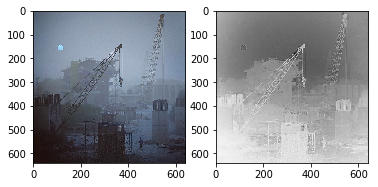

In [13]:
ex1 = cv2.imread('../img/23421585_2173637236196783_3015774036358594560_n.jpg',1)
ex1_trans = cv2.imread('../img/23421585_2173637236196783_3015774036358594560_n_trans.jpg',0)
plt.subplot(1, 2, 1), plt.imshow(ex1)
plt.subplot(1, 2, 2), plt.imshow(ex1_trans)

In [41]:
print(np.max(np.array(actual)))
print(np.min(np.array(actual)))

988.4019775390625
-4.0


In [42]:
print(np.mean(np.array(actual)))
print(np.std(np.array(actual)))

105.9935740450383
110.91371254033635


In [47]:
print(np.mean(np.abs(err_val)))
print(np.mean(np.abs(err_train)))

28.735343353775725
4.87415483408051
